In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pandas as pd
from sklearn.metrics import r2_score

sys.path.append(os.path.abspath('../database'))

from db_connection import get_connection

conexion = get_connection()

2025-05-22 22:40:02,900 - INFO - Conexión a la base de datos 'kafka' creada exitosamente.


In [3]:
data = pd.read_sql_query("SELECT * FROM predictions", conexion)
data.head()

,freedom,generosity,perceptions_of_corruption,gdp_per_capita,healthy_life_expectancy,social_support,year,region_australia_and_new_zealand,region_central_and_eastern_europe,region_eastern_asia,region_latin_america_and_caribbean,region_middle_east_and_northern_africa,region_north_america,region_southeastern_asia,region_southern_asia,region_sub_saharan_africa,region_western_europe,happiness_score_predicted,happiness_score_actual
0,0.142000,0.275000,0.078000,0.274000,0.505000,0.757000,2019,0,0,0,0,0,0,0,0,1,0,3.579337,3.973
1,0.658249,0.415984,0.246528,0.786441,0.498273,1.548969,2017,0,1,0,0,0,0,0,0,0,0,5.595827,5.971
2,0.043200,0.202900,0.094190,0.068310,0.157470,0.234420,2016,0,0,0,0,0,0,0,0,1,0,3.047754,2.905
3,0.244250,0.461870,0.171750,0.266730,0.388470,0.743020,2015,0,0,0,1,0,0,0,0,0,0,4.549459,4.518
4,0.457000,0.370000,0.167000,0.813000,0.604000,1.321000,2019,0,0,0,0,0,0,0,1,0,0,4.986574,5.082


In [4]:
data.shape

(235, 19)

In [5]:
y = data["happiness_score_actual"]
y_predicted = data["happiness_score_predicted"]

r2 = r2_score(y, y_predicted)

print(f"R2 Score: {r2}")


R2 Score: 0.8998046966354161


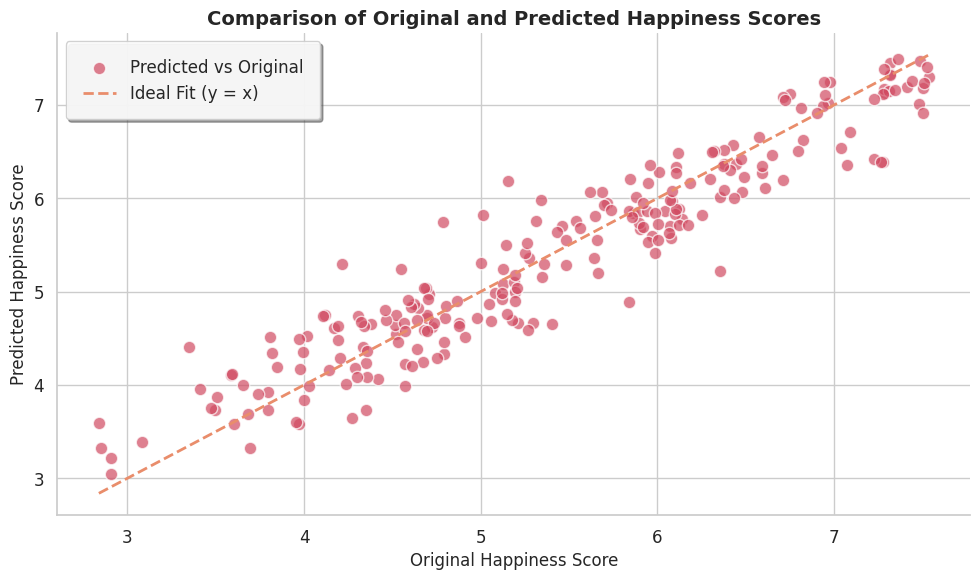

In [ ]:
sns.set_theme(style="whitegrid", palette="flare", font_scale=1.1)

plt.figure(figsize=(10, 6))

plt.scatter(y, y_predicted, 
            label="Predicted vs Original", 
            color=sns.color_palette("flare")[2], 
            alpha=0.7, 
            edgecolor="white", 
            s=80)

min_val = min(y.min(), y_predicted.min())
max_val = max(y.max(), y_predicted.max())
plt.plot([min_val, max_val], [min_val, max_val], 
         color=sns.color_palette("flare")[0], 
         linestyle="--", 
         linewidth=2, 
         label="Ideal Fit (y = x)")

plt.xlabel("Original Happiness Score", fontsize=12)
plt.ylabel("Predicted Happiness Score", fontsize=12)
plt.title("Comparison of Original and Predicted Happiness Scores", fontsize=14, weight='bold')

plt.legend(frameon=True, framealpha=0.9, shadow=True, borderpad=1)

sns.despine()
plt.tight_layout()
plt.show()


- La mayoría de los puntos se agrupan cerca de la línea ideal (y = x), lo que indica que las predicciones del modelo son generalmente precisas y se alinean bien con los Happiness Scores originales.
- Hay una correlación positiva fuerte entre los valores originales y los predichos, lo que es consistente con el alto R² del conjunto de prueba reportado previamente (0.8998 para CatBoost), sugiriendo que el modelo captura bien la variabilidad en los datos.
- Para los valores extremos (Happiness Scores menores a 4 o mayores a 7), las predicciones tienden a ser más precisas, con menos dispersión, lo que sugiere que el modelo maneja bien los casos de felicidad muy baja o muy alta.

In [5]:
import joblib
model = joblib.load("../models/catboost_model.pkl")

/tmp/ipykernel_613/2044356420.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


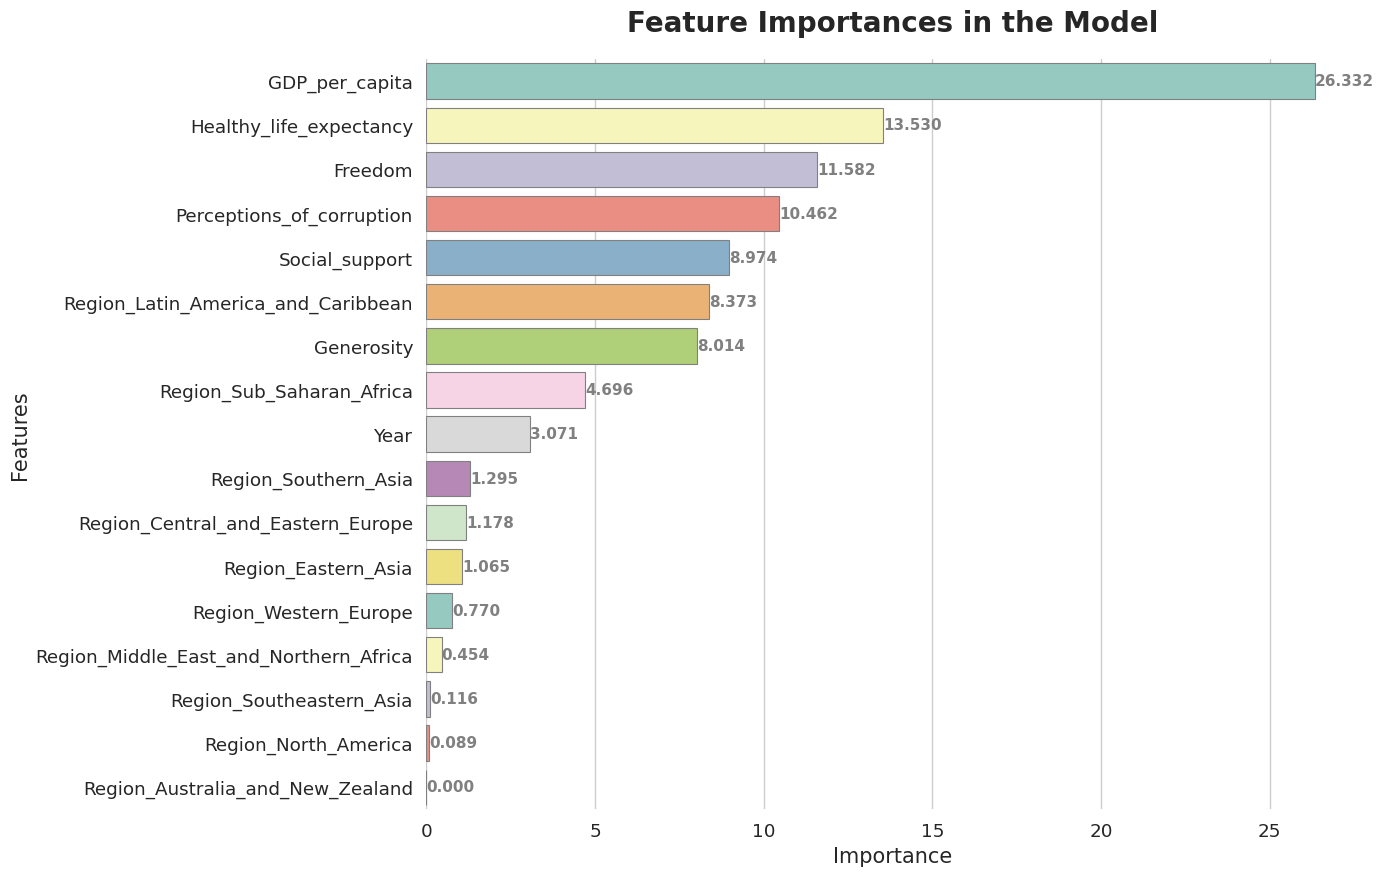

In [10]:
model_features = model.feature_names_
feature_importances = model.feature_importances_

features_df = pd.DataFrame({
    "Feature": model_features,
    "Importance": feature_importances
})

# Configuración general de estilo
import matplotlib.pyplot as plt
import seaborn as sns


pastel_palette = sns.color_palette('Set3', len(features_df))

sns.set_theme(style="whitegrid", font_scale=1.2)

features_df = features_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(14, 9))

barplot = sns.barplot(
    x="Importance", 
    y="Feature", 
    data=features_df, 
    palette=pastel_palette,
    edgecolor="gray",
    linewidth=0.8
)

# Añadir valores al final de cada barra
for i, (value, feature) in enumerate(zip(features_df["Importance"], features_df["Feature"])):
    barplot.text(
        value + 0.005, 
        i, 
        f"{value:.3f}", 
        color='gray', 
        va='center',
        fontweight='bold',
        fontsize=11
    )

plt.title("Feature Importances in the Model", fontsize=20, weight='bold', pad=20)
plt.xlabel("Importance", fontsize=15)
plt.ylabel("Features", fontsize=15)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()


- PIB per cápita es la característica más importante con un valor de 26.332, lo que indica que el ingreso económico tiene el mayor impacto en la predicción del Happiness Score. Esto es consistente con la alta correlación observada previamente (0.789284).
- Esperanza de vida saludable (13.530) y Libertad (11.582) también tienen una gran influencia, reforzando que la salud y la autonomía personal son factores clave para la felicidad.
- Percepciones de corrupción (10.462) y Apoyo social (8.974) siguen en importancia, mostrando que la confianza en las instituciones y las conexiones sociales contribuyen significativamente a las predicciones del modelo.
- Generosidad (8.014) tiene una importancia moderada, a pesar de su baja correlación con el Happiness Score (0.137578), lo que sugiere que el modelo puede estar capturando interacciones no lineales con otras variables.
- Las regiones tienen una importancia variable:
    - América Latina y el Caribe (8.373) y África Subsahariana (4.966) tienen un impacto notable, probablemente porque estas regiones representan extremos en el espectro de felicidad (puntajes altos y bajos, respectivamente).
    - Otras regiones como Asia del Sur (1.295), Europa Central y del Este (1.178), y Asia del Este (1.065) tienen menor influencia.
    - Regiones como Australia y Nueva Zelanda (0.000) y América del Norte (0.089) tienen una importancia casi nula, posiblemente porque su Happiness Score es consistentemente alto y no aporta variabilidad significativa al modelo.
- Año (3.071) tiene una importancia baja, lo que coincide con su correlación casi nula con el Happiness Score (0.007065), indicando que las variaciones temporales no son un factor predictivo fuerte.